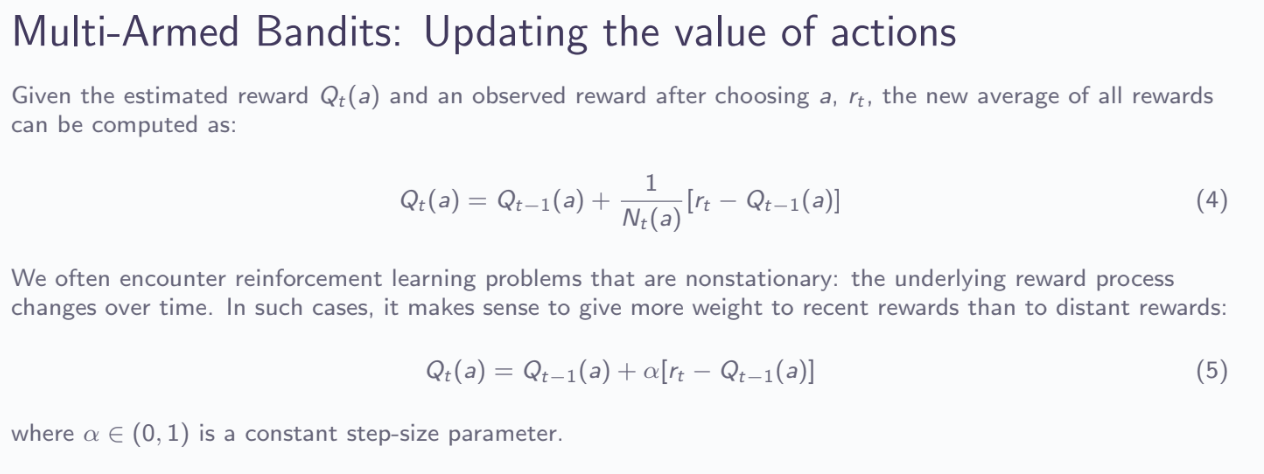

It is easy to devise incremental formulas for updating averages with small, constant computation required to process each new reward. That is, we do not need to keep track of all the history of rewards. Given the estimated reward $Q_t(a)$ and and an observed reward after choosing $a$, $r_t$, the new average of all rewards can be computed as:
$$
\begin{align}
Q_t(a) = Q_{t-1}(a) + \frac{1}{N_t(a)}[r_t - Q_{t-1}(a)]
\end{align}
$$
where $N_t(a)$ measures the number of times that $a$ has been chosen up to and including time step $t$. This averaging method is appropriate for stationary problems, that is, when the reward probabilities do not change over time. We often encounter reinforcement learning problems that are effectively nonstationary: the underlying reward process changes over time. This is the most likely case in financial applications. In such cases, it makes sense to give more weight to recent rewards than to distant rewards. One of the most popular ways of doing this is to use a constant step-size parameter $\alpha\in(0,1)$:
$$
\begin{align}
Q_t(a) = Q_{t-1}(a) + \alpha[r_t - Q_{t-1}(a)]
\end{align}
$$
Notice that if $n$ denotes the number of times that action $a$ has been taken, we can re-express the function $Q(a)$ as just a weighted average of the past rewards obtained from choosing $a$ and a potential initial estimate $Q_0(a)$ (which might be zero in many instances):
$$
\begin{align}
Q_n(a) & = \alpha r_n + (1-\alpha)Q_{n-1}(a) \\
& = \alpha r_n + (1-\alpha)[\alpha r_{n-1} + (1-\alpha)Q_{t-2}(a)] \\
& = \alpha r_n + (1-\alpha)\alpha r_{t-1} + (1-\alpha)^2\alpha r_{n-2} + ... +(1-\alpha)^{n-1}\alpha r_{1} + (1-\alpha)^nQ_{0}(a)] \\
& =  (1-\alpha)^nQ_{0}(a) + \alpha\sum_{i=1}^n (1-\alpha)^{n-i}r_{i}
\end{align}
$$
Notice that the weight given to each reward $r_i$ declines as the number of new draws from choosing action $a$ increases.

# Stationary case

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def choose_action(q_values, epsilon):
    """
    Selects an action using the epsilon-greedy policy.
    With probability epsilon, selects a random action.
    Otherwise, selects the action with the highest estimated value.
    In case of a tie, randomly selects among the best actions.
    """
    n_actions = len(q_values)
    if np.random.rand() < epsilon:
        # Explore: select a random action
        action = np.random.randint(n_actions)
    else:
        # Exploit: select the best action (with random tie-breaking)
        max_value = np.max(q_values)
        best_actions = np.where(q_values == max_value)[0]
        action = np.random.choice(best_actions)
    return action

# Parameters
n_actions = 10         # Number of bandit arms
n_steps = 1000         # Number of steps per episode
epsilon_values = [0.0, 0.1]  # Epsilon values for epsilon-greedy policies
n_episodes = 1000      # Number of episodes to average over

np.random.seed(1234)

# Initialize the true value of each action (stationary problem)
true_action_values = np.random.normal(loc=0.0, scale=1.0, size=n_actions)
print("True action values:", true_action_values)

# Arrays to store the average rewards and optimal action counts
average_rewards = np.zeros((n_steps, len(epsilon_values)))
optimal_action_counts = np.zeros((n_steps, len(epsilon_values)))

for idx, epsilon in enumerate(epsilon_values):
    for episode in range(n_episodes):
        # Initialize estimated action values and action counts
        q_values = np.zeros(n_actions)
        action_counts = np.zeros(n_actions)
        for step in range(n_steps):
            action = choose_action(q_values, epsilon)
            # Get reward from a normal distribution centered at the true action value
            reward = np.random.normal(loc=true_action_values[action], scale=1.0)
            action_counts[action] += 1
            # Update the estimated value of the chosen action using incremental formula
            alpha = 1.0 / action_counts[action]
            q_values[action] += alpha * (reward - q_values[action])
            # Update statistics for plotting
            average_rewards[step, idx] += reward / n_episodes
            optimal_action = np.argmax(true_action_values)
            if action == optimal_action:
                optimal_action_counts[step, idx] += 1 / n_episodes

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot average reward over time
plt.subplot(1, 2, 1)
plt.plot(average_rewards[:, 0], label="Greedy")
plt.plot(average_rewards[:, 1], label="0.1-Greedy")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward over Time")
plt.legend()

# Plot percentage of optimal action selection over time
plt.subplot(1, 2, 2)
plt.plot(optimal_action_counts[:, 0], label="Greedy")
plt.plot(optimal_action_counts[:, 1], label="0.1-Greedy")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.title("Optimal Action over Time")
plt.legend()

plt.show()

True action values: [ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


KeyboardInterrupt: 

# Non-Stationary case

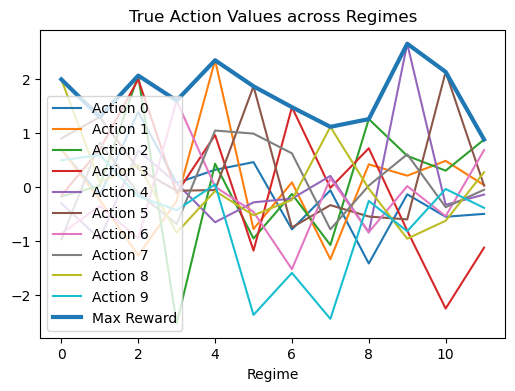

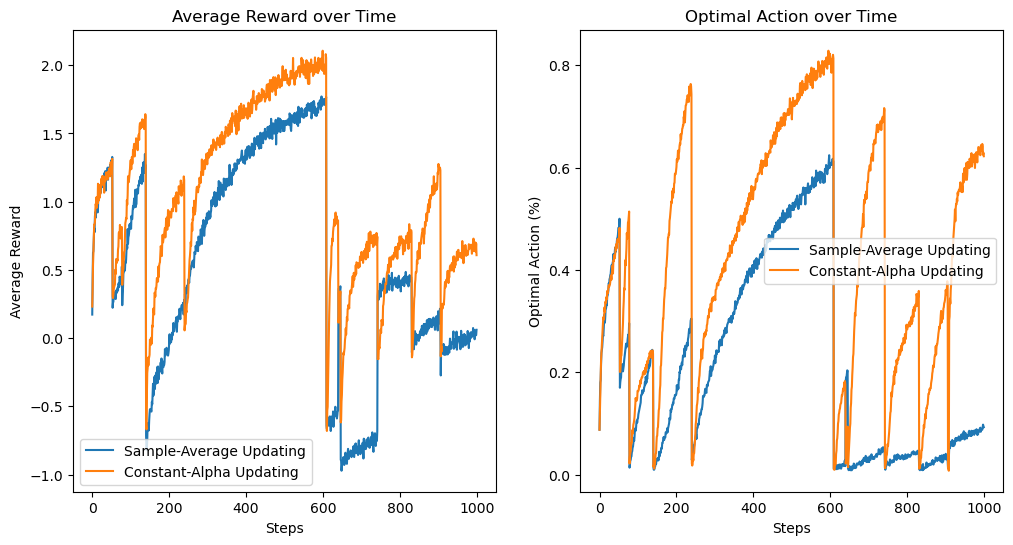

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(1234)

# Parameters for the non-stationary k-armed bandit problem
n_actions = 10          # Number of bandit arms
n_steps = 1000          # Number of time steps per episode
n_episodes = 1000       # Number of episodes to average over
epsilon = 0.1           # Epsilon value for epsilon-greedy policy
alpha = 0.2             # Step-size parameter for constant-alpha update
p_change = 0.01         # Probability of environment change at each time step

def choose_action(q_values, epsilon):
    """
    Selects an action using the epsilon-greedy policy.
    With probability epsilon, selects a random action (exploration).
    Otherwise, selects the action with the highest estimated value (exploitation).
    In case of a tie, randomly selects among the best actions.
    """
    if np.random.rand() < epsilon:
        # Explore: select a random action
        return np.random.randint(len(q_values))
    else:
        # Exploit: select the best action(s)
        max_value = np.max(q_values)
        best_actions = np.where(q_values == max_value)[0]
        # Randomly select among the best actions
        return np.random.choice(best_actions)

# Determine time steps where the environment changes
change_points = []
for t in range(n_steps):
    if np.random.rand() < p_change:
        change_points.append(t)

# Total number of regimes (initial plus changes)
n_regimes = len(change_points) + 1

# Generate true action values for each regime
true_action_values = np.random.normal(loc=0.0, scale=1.0, size=(n_actions, n_regimes))

# Plot the true action values across regimes
plt.figure(figsize=(6, 4))
for i in range(n_actions):
    plt.plot(true_action_values[i, :], label=f"Action {i}")
plt.plot(np.max(true_action_values, axis=0), linewidth=3.0, label="Max Reward")
plt.xlabel("Regime")
plt.title("True Action Values across Regimes")
plt.legend()
plt.show()

# Arrays to store the average rewards and optimal action counts for both methods
average_rewards = np.zeros((n_steps, 2))
optimal_action_counts = np.zeros((n_steps, 2))

# Create a list of change points including the final step
next_change_points = change_points + [n_steps]

# Loop over two updating methods: 0 - sample-average, 1 - constant-alpha
for method in range(2):
    for episode in range(n_episodes):
        # Initialize estimated action values and action counts
        q_values = np.zeros(n_actions)
        action_counts = np.zeros(n_actions)
        
        # Initialize variables to track the current regime
        regime_index = 0
        next_change = next_change_points[regime_index]
        current_true_values = true_action_values[:, regime_index]
        
        for step in range(n_steps):
            # Check if it's time to switch to the next regime
            if step == next_change:
                regime_index += 1
                if regime_index < n_regimes:
                    current_true_values = true_action_values[:, regime_index]
                    next_change = next_change_points[regime_index]
            
            # Select an action using epsilon-greedy policy
            action = choose_action(q_values, epsilon)
            
            # Generate reward from a normal distribution centered at the true action value
            reward = np.random.normal(loc=current_true_values[action], scale=1.0)
            
            # Update action counts
            action_counts[action] += 1
            
            # Determine step-size parameter (alpha)
            if method == 0:
                # Sample-average updating: alpha = 1 / N
                step_size = 1.0 / action_counts[action]
            else:
                # Constant-alpha updating: alpha = constant
                step_size = alpha
            
            # Update estimated action value using incremental formula
            q_values[action] += step_size * (reward - q_values[action])
            
            # Update statistics for plotting
            average_rewards[step, method] += reward / n_episodes
            optimal_action = np.argmax(current_true_values)
            if action == optimal_action:
                optimal_action_counts[step, method] += 1 / n_episodes

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot average reward over time for both methods
plt.subplot(1, 2, 1)
plt.plot(average_rewards[:, 0], label="Sample-Average Updating")
plt.plot(average_rewards[:, 1], label="Constant-Alpha Updating")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward over Time")
plt.legend()

# Plot percentage of optimal action selection over time for both methods
plt.subplot(1, 2, 2)
plt.plot(optimal_action_counts[:, 0], label="Sample-Average Updating")
plt.plot(optimal_action_counts[:, 1], label="Constant-Alpha Updating")
plt.xlabel("Steps")
plt.ylabel("Optimal Action (%)")
plt.title("Optimal Action over Time")
plt.legend()

plt.show()


# UCB (Upper Confidence Bound) Method

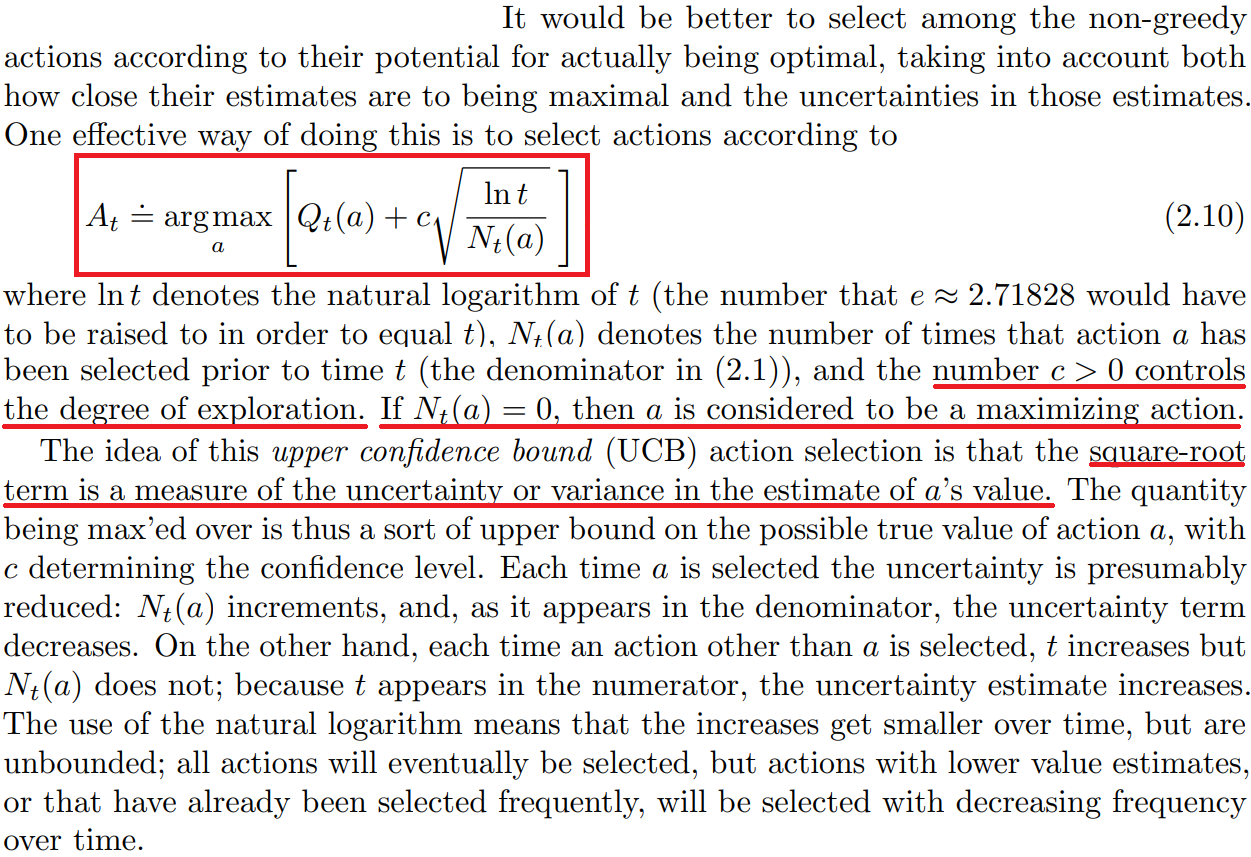

# Gradient Bandit Algorithms

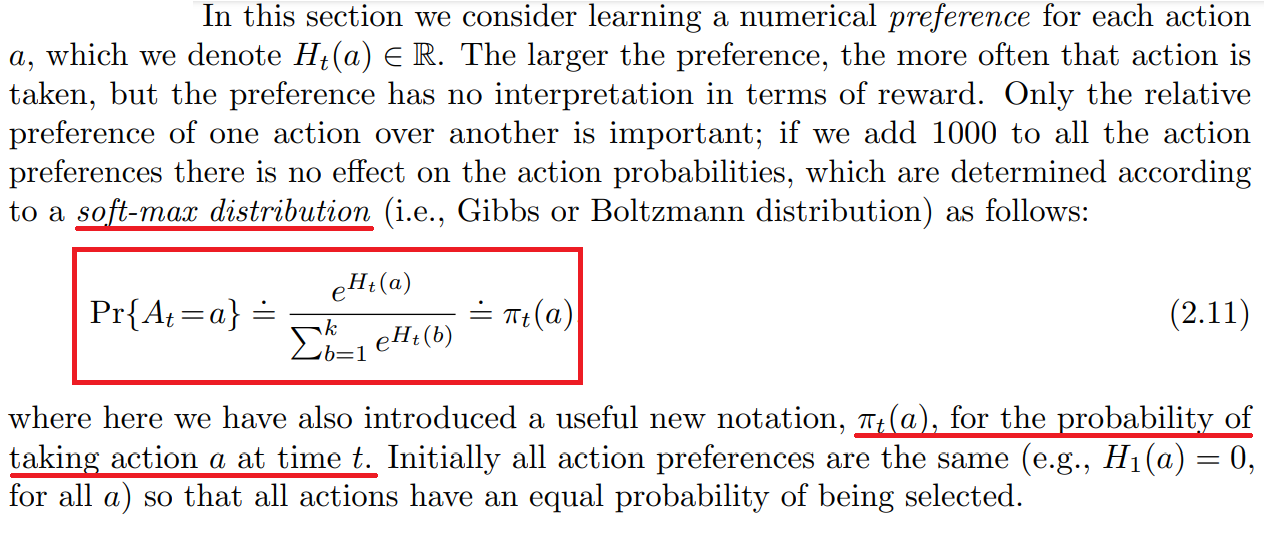

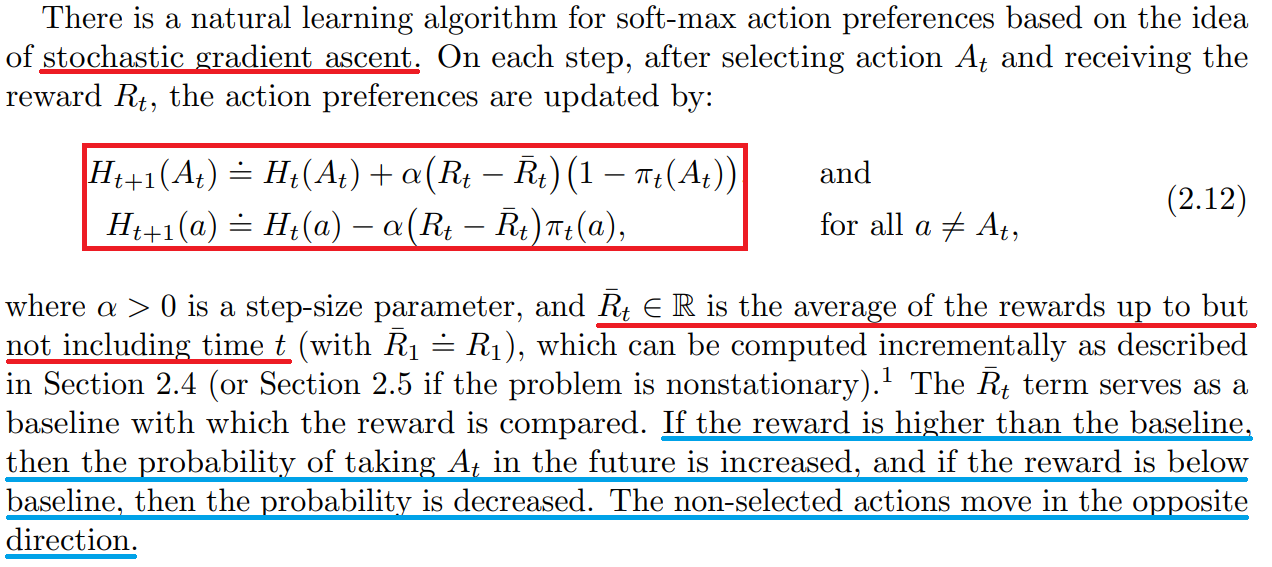

_________

# Fine tuning techniques for Multi-Armed Bandit problems

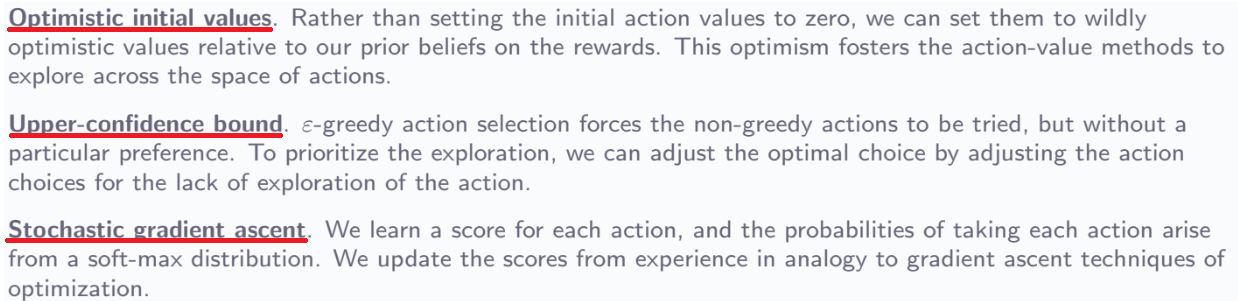

# Stock picking problem

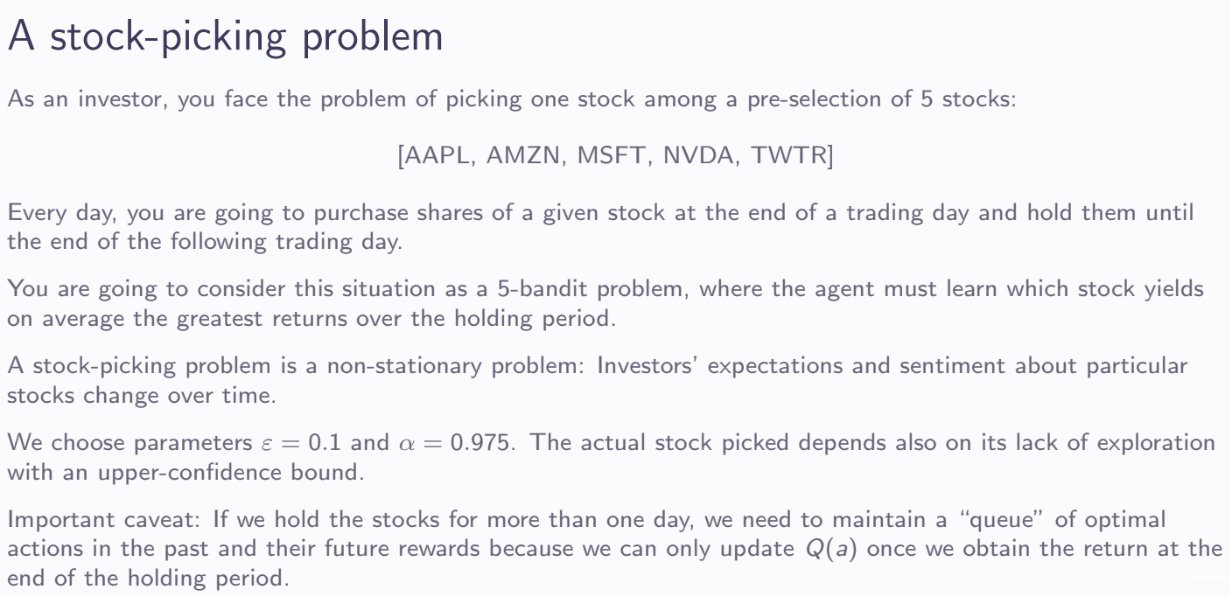

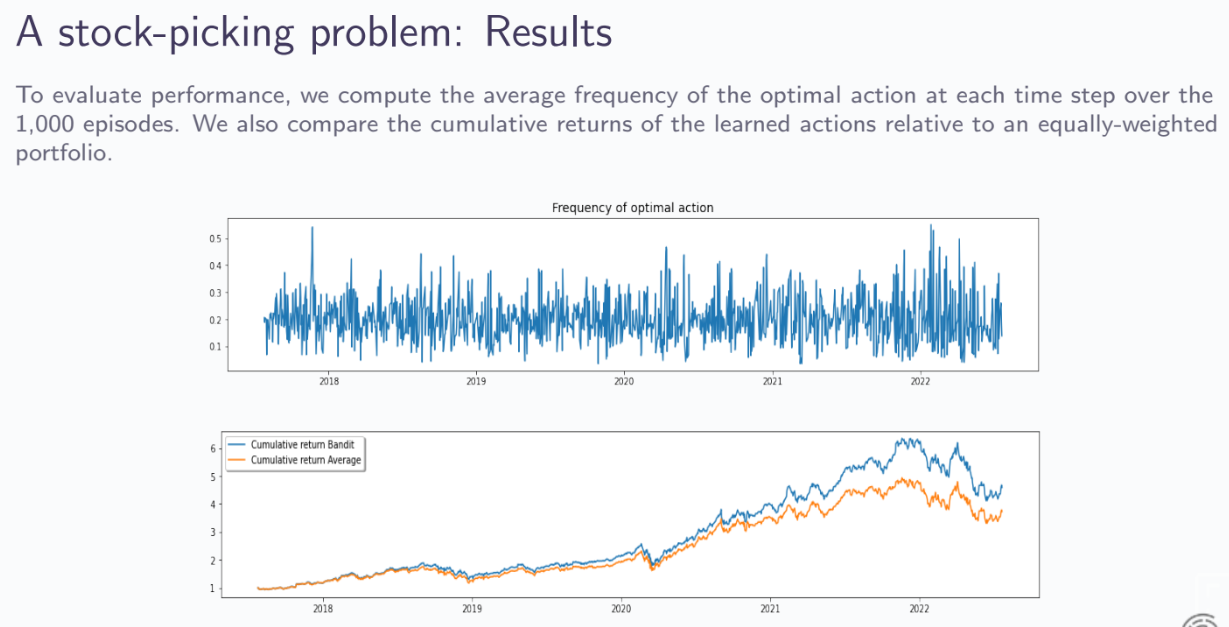

_________

## **1. Fine-Tuning Techniques**

### **1.1 Optimistic Initial Values**

Initial action values can also be used as fine-tuning tool to encourage the exploration of actions. Rather than setting the initial action values to zero, we can set them to wildly optimistic values relative to our prior beliefs on the rewards. This optimism encourages the use of action-value methods to explore across the space of actions. While this may be of help in the stationary case, any method that focuses on the initial conditions is unlikely to help with the general nonstationary case.

### **1.2 Upper-Confidence Bound**

We need to induce some degree of exploration in the actions because we are always uncertain about our action-value estimates. The greedy actions are the currently optimal ones from a backward-looking perspective, but some of the other actions may be better without us actually knowing. However, $\varepsilon$-greedy action selection forces the non-greedy actions to be tried, but without a particular preference.

To overcome this, and prioritize the exploration of actions that we are more uncertain about, we can  follow the next optimal choice:
$$
\begin{equation}
A_t = \arg\underset{a}{\max} \left\{Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right\}
\end{equation}
$$
where the new term adjusts for the degree of "unexploration" of the action relative to the steps completed. The parameter $c>0$ controls the degree of exploration. If $N_t(a)=0$, $a$ is considered to be a maximizing action to avoid the ratio to be infinite. We will implement this procedure in the application to stock-picking strategies below.

### **1.3 Stochastic Gradient Ascent**

The methods above estimate action values and use those estimates to select actions deterministically. We can also opt for a stochastic selection. We consider learning a score or preference for each action a, which we denote $Y_t(a)$. The larger the score, the more often that action is taken, but the preference has no interpretation in terms of reward. Only the relative preference of one action over the others is important. The probabilities of taking each action arises from a soft-max distribution:
$$
\begin{equation}
\pi_t(a) = \frac{\exp(Y_t(a))}{\sum_{b\in\mathcal{A}}\exp(Y_t(b))}
\end{equation}
$$
Initially, all action preferences are the same (e.g., $Y_0(a) = 0$, for all $a$) so that all actions have an equal probability of being selected.

There is a natural learning algorithm for this setting based on the idea of stochastic gradient ascent. On each step, after selecting action $a_t$ and receiving the reward $r_t$, the action preferences are updated by:
$$
\begin{equation}
Y_{t+1}(a) = Y_{t}(a) + \alpha (r_t - \overline{r}_t) (1-\pi_t(a))\ if\ a=a_t
\end{equation}
$$
$$
\begin{equation}
Y_{t+1}(a) = Y_{t}(a) - \alpha (r_t - \overline{r}_t)\pi_t(a)\ if\ a\neq a_t
\end{equation}
$$
where $\alpha > 0$ is a step-size parameter as introduced above, and $\overline{r}_t$ is the average of all the rewards up through and including time t.

This method embeds the $\varepsilon$-greedy action choice allowing for time-varying probability of action selection according to past experience. However, stochastic gradient descent is prone to generate similar issues as averaging in the case of non-stationary data. This issue arises because the choice of action depends on the estimated scores, which are less sensitive to changes in the rewards of the actions after the agent has gone through decisions in many time steps.

## **2. A Stock-Picking Problem**

As an investor, you face the problem of picking one stock among a pre-selection of 5 stocks. Every day, you are going to purchase shares of a given stock and hold it for one trading day. Suppose that you have unlimited funding or at least enough to make any of the required trades in this exercise. 

You are going to consider this situation as a 5-bandit problem, where we want to learn which stock yields on average the greatest profit over the holding period. Notice that a stock-picking problem is a non-stationary problem by nature, since investors' expectations and sentiment about particular stocks change over time. Moreover, contrary to the examples from previous lessons, we have lost control of the data-generation process; it is a given to us.

We first load the data and some additional libraries.

The sample period covers 25 Jul 2017 to 22 Jul 2022


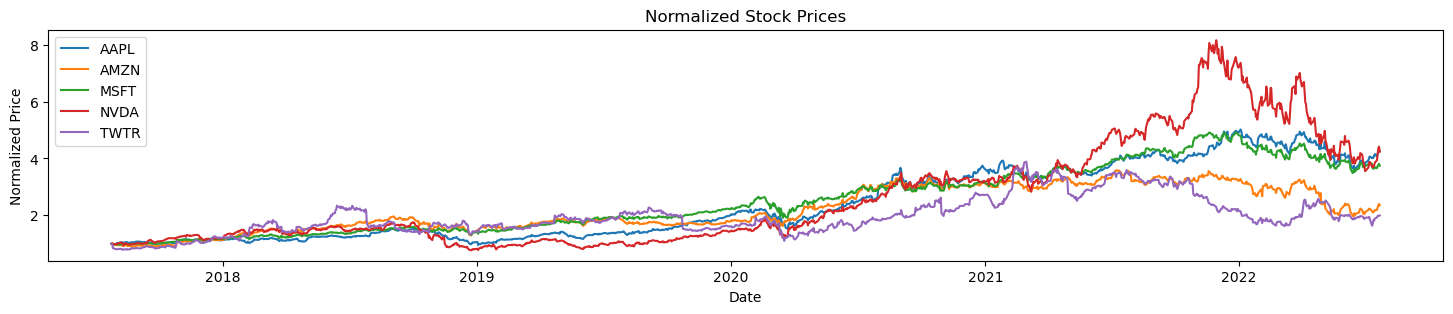

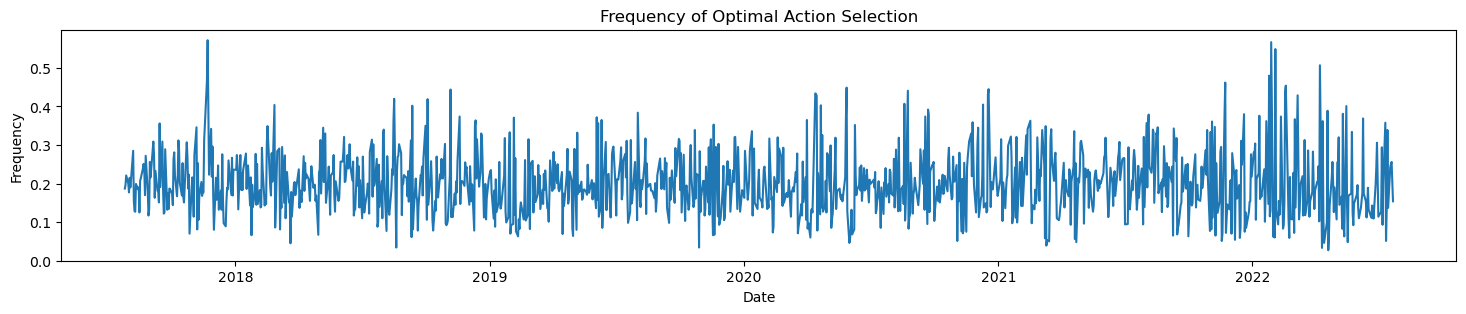

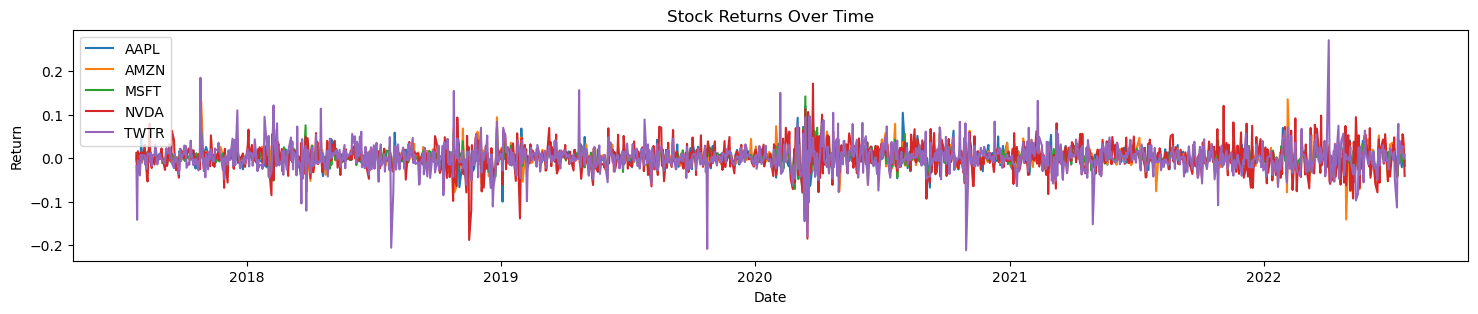

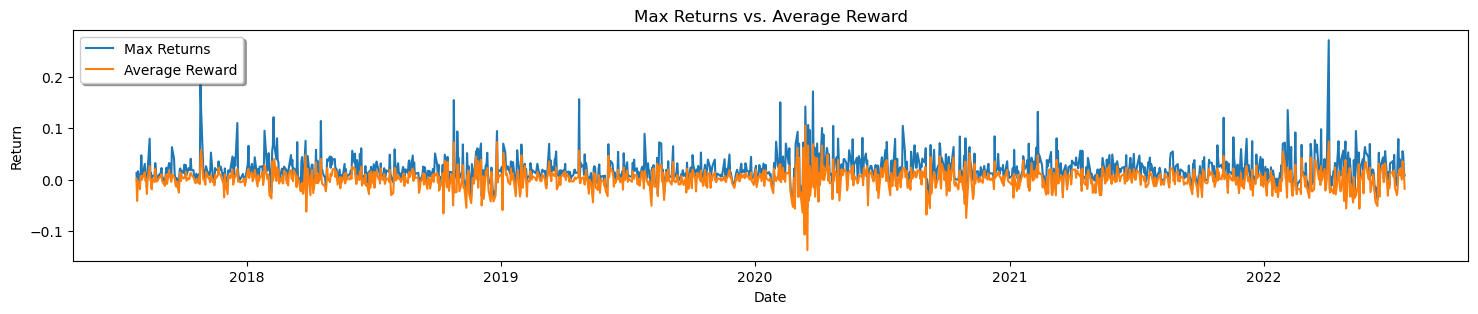

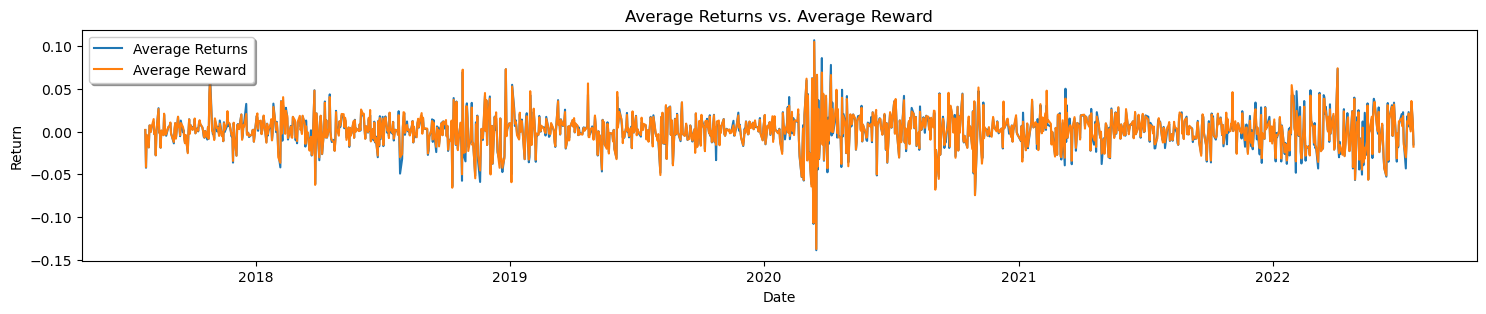

Average frequency of optimal action: 0.2006
Annualized return of equally-weighted portfolio: 0.3665, Std Dev: 0.3173
Annualized return of Bandit portfolio: 0.4272, Std Dev: 0.3087


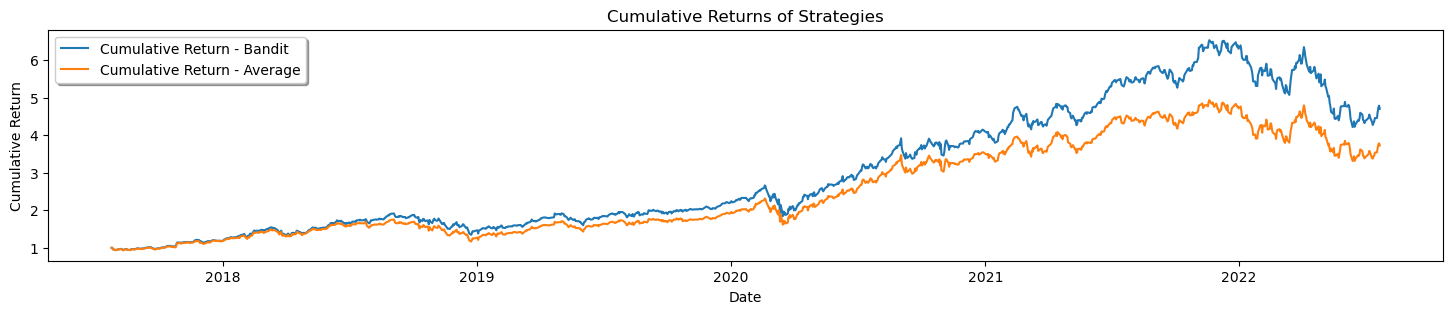

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(1234)

def choose_action(q_values, epsilon):
    """
    Selects an action using the epsilon-greedy policy with UCB adjustment.
    With probability epsilon, selects a random action (exploration).
    Otherwise, selects the action with the highest estimated value (exploitation).
    In case of a tie, randomly selects among the best actions.
    """
    n_actions = len(q_values)
    max_value = np.max(q_values)
    best_actions = np.where(q_values == max_value)[0]

    if np.random.rand() < epsilon:
        # Explore: select a random action
        return np.random.randint(n_actions)
    else:
        # Exploit: select among the best actions randomly
        return np.random.choice(best_actions)

def update_q_value(action, reward, q_values, alpha):
    """
    Updates the estimated Q-value for the given action using the incremental update formula.
    """
    q_values[action] += alpha * (reward - q_values[action])
    return q_values

# List of stock tickers to analyze
tickers = ["AAPL", "AMZN", "MSFT", "NVDA", "TWTR"]

# Read adjusted close prices for each ticker and store in a DataFrame
prices_list = []
for ticker in tickers:
    data = pd.read_csv(f"{ticker}.csv", usecols=['Date', 'Adj Close'])
    data.rename(columns={'Adj Close': ticker}, inplace=True)
    prices_list.append(data)

# Merge all dataframes on 'Date'
prices_df = prices_list[0]
for df in prices_list[1:]:
    prices_df = pd.merge(prices_df, df, on='Date')

# Convert 'Date' column to datetime and set as index
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
dates = prices_df['Date']
prices_df.set_index('Date', inplace=True)

print(f"The sample period covers {dates.iloc[0].strftime('%d %b %Y')} to {dates.iloc[-1].strftime('%d %b %Y')}")

# Plot normalized prices
normalized_prices = prices_df / prices_df.iloc[0]
plt.figure(figsize=(18, 3))
for ticker in tickers:
    plt.plot(dates, normalized_prices[ticker], label=ticker)
plt.legend()
plt.title("Normalized Stock Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.show()

# Parameters for the bandit problem
num_actions = len(tickers)    # Number of stocks (actions)
epsilon = 0.1                 # Exploration rate for epsilon-greedy policy
alpha = 0.975                 # Learning rate for updating Q-values
n_episodes = 1000             # Number of episodes to average over
hold_period = 1               # Holding period for the stocks
n_steps = prices_df.shape[0] - hold_period  # Number of time steps

# Arrays to store average rewards and optimal action counts
average_rewards = np.zeros(n_steps)
optimal_action_counts = np.zeros(n_steps)

# Main simulation loop
for episode in range(n_episodes):
    # Initialize estimated Q-values and action counts
    q_values = np.zeros(num_actions)
    action_counts = np.zeros(num_actions)
    # Reward queue to handle delayed rewards due to holding period
    reward_queue = np.zeros((hold_period, 2))  # Each row: [reward, action]
    
    for t in range(n_steps):
        # Select an action using epsilon-greedy policy with UCB adjustment
        q_values_ucb = np.copy(q_values)
        for a in range(num_actions):
            if action_counts[a] == 0:
                # Assign a high value to encourage trying unselected actions
                q_values_ucb[a] = np.max(q_values) + 1.0
            else:
                # UCB adjustment to balance exploration and exploitation
                q_values_ucb[a] += np.sqrt(np.log(t + 1) / action_counts[a])
        
        action = choose_action(q_values_ucb, epsilon)
        action_counts[action] += 1
        
        # Compute the reward as return over the holding period
        current_price = prices_df.iloc[t, action]
        future_price = prices_df.iloc[t + hold_period, action]
        reward = (future_price - current_price) / current_price
        
        # Store the reward and action in the reward queue
        reward_queue[-1, :] = [reward, action]
        
        # Update Q-values using the reward from 'hold_period' days ago
        if t >= hold_period:
            past_reward, past_action = reward_queue[0, :]
            past_action = int(past_action)
            q_values = update_q_value(past_action, past_reward, q_values, alpha)
        
        # Shift the reward queue to prepare for the next time step
        reward_queue[:-1, :] = reward_queue[1:, :]
        
        # Collect statistics for plotting
        average_rewards[t] += reward / n_episodes
        
        # Determine the optimal action at this time step
        future_returns = (prices_df.iloc[t + hold_period] - prices_df.iloc[t]) / prices_df.iloc[t]
        optimal_action = future_returns.idxmax()
        if tickers[action] == optimal_action:
            optimal_action_counts[t] += 1 / n_episodes

# Plot the frequency of selecting the optimal action over time
plt.figure(figsize=(18, 3))
plt.plot(dates[hold_period:], optimal_action_counts)
plt.title("Frequency of Optimal Action Selection")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.show()

# Compute and plot returns over time for each stock
returns = (prices_df.iloc[hold_period:].values - prices_df.iloc[:-hold_period].values) / prices_df.iloc[:-hold_period].values
plt.figure(figsize=(18, 3))
for i, ticker in enumerate(tickers):
    plt.plot(dates[hold_period:], returns[:, i], label=ticker)
plt.legend()
plt.title("Stock Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

# Plot maximum returns vs. average rewards
max_returns = np.max(returns, axis=1)
plt.figure(figsize=(18, 3))
plt.plot(dates[hold_period:], max_returns, label="Max Returns")
plt.plot(dates[hold_period:], average_rewards, label="Average Reward")
plt.legend(loc="upper left", shadow=True)
plt.title("Max Returns vs. Average Reward")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

# Plot average returns vs. average rewards
average_returns = np.mean(returns, axis=1)
plt.figure(figsize=(18, 3))
plt.plot(dates[hold_period:], average_returns, label="Average Returns")
plt.plot(dates[hold_period:], average_rewards, label="Average Reward")
plt.legend(loc="upper left", shadow=True)
plt.title("Average Returns vs. Average Reward")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

# Calculate and print performance metrics
print(f"Average frequency of optimal action: {np.mean(optimal_action_counts):.4f}")

# Average annualized return from holding the equally-weighted portfolio
mean_return = np.mean(returns)
annualized_return = (1 + mean_return) ** (250 / hold_period) - 1
annualized_std = np.sqrt(250 / hold_period) * np.std(np.mean(returns, axis=1))
print(f"Annualized return of equally-weighted portfolio: {annualized_return:.4f}, Std Dev: {annualized_std:.4f}")

# Average annualized return from the Bandit strategy
mean_reward = np.mean(average_rewards)
annualized_reward_return = (1 + mean_reward) ** (250 / hold_period) - 1
annualized_reward_std = np.sqrt(250 / hold_period) * np.std(average_rewards)
print(f"Annualized return of Bandit portfolio: {annualized_reward_return:.4f}, Std Dev: {annualized_reward_std:.4f}")

# Compute cumulative returns for both strategies
cumulative_returns = np.zeros((n_steps + 1, 2))
cumulative_returns[0, :] = 1  # Starting with $1 investment

for t in range(1, n_steps + 1):
    # Bandit cumulative return
    cumulative_returns[t, 0] = cumulative_returns[t - 1, 0] * (1 + average_rewards[t - 1])
    # Equally-weighted portfolio cumulative return
    mean_return = np.mean(returns[t - 1])
    cumulative_returns[t, 1] = cumulative_returns[t - 1, 1] * (1 + mean_return)

# Plot cumulative returns for both strategies
plt.figure(figsize=(18, 3))
plt.plot(dates[hold_period - 1:], cumulative_returns[:, 0], label="Cumulative Return - Bandit")
plt.plot(dates[hold_period - 1:], cumulative_returns[:, 1], label="Cumulative Return - Average")
plt.legend(loc="upper left", shadow=True)
plt.title("Cumulative Returns of Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()


__________

Quiz

In [93]:
np.random.seed(1234)

true_action_values = np.random.normal(0, 1, 2)
print("true_action_values =", true_action_values)

Q = np.array([0.0, 0.0], dtype=np.float64)  # initial values

alpha = 0.95
a_count_dict = {0:0, 1:0}

for i in range(3):
    a = Q.argmax()  # select greedy action

    a_count_dict[a] += 1  # one more action a selected

    r = np.random.normal(true_action_values[a], 1.5)  # generate random reward

    # Q[a] = Q[a] + (r - Q[a]) * alpha
    Q[a] = Q[a] + (r - Q[a]) / a_count_dict[a]
    print("Q =", Q)
Q

true_action_values = [ 0.47143516 -1.19097569]
Q = [2.62049562 0.        ]
Q = [1.31147647 0.        ]
Q = [0.67116833 0.        ]


array([0.67116833, 0.        ])

In [57]:
import numpy as np

# Set the random seed
np.random.seed(1234)

# Generate true action values from a normal distribution (mean = 0, std = 0.5)
true_action_values = np.random.normal(0, 0.5, 2)

# Initialize Q values and action counts
Q = np.array([0.0, 0.0])  # Initial estimated values
action_counts = {0: 0, 1: 0}

# Simulate the agent's actions over 3 steps, following the greedy policy
for _ in range(3):
    # Select the greedy action (the action with the highest Q value)
    action = Q.argmax()
    
    # Increment the count for the selected action
    action_counts[action] += 1
    
    # Draw a reward for the selected action based on its true value
    reward = np.random.normal(true_action_values[action], 1)
    
    # Update the Q value using the incremental average formula
    Q[action] = Q[action] + (reward - Q[action]) / action_counts[action]

Q

array([0.36887303, 0.        ])